In [25]:
import sqlite3
import pandas as pd
import struct
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Layer
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import os

### Vectorización de audio features

In [ ]:
def load_data():
    """ Lee features de la base de datos features.db"""

    features_db_path = "dataset/features.db"
    genres_db_path = "dataset/genres.db"
    metadata_db_path = "dataset/metadata.db"
    tags_db_path = "dataset/tags.db"

    conn = sqlite3.connect(features_db_path)
    features_df = pd.read_sql_query("SELECT * FROM features", conn)
    conn.close()

    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    if not os.path.exists("models"):
        os.makedirs("models")

    return features_df, genres_df, metadata_df, tags_df

features_df, genres_df, metadata_df, tags_df = load_data()

In [3]:
def decode_tempo(b):
    try:
        if isinstance(b, float):
            return b
        if isinstance(b, (bytes, bytearray)) and len(b) == 4:
            return struct.unpack('f', b)[0]  # <-- 'f' = float32 (4 bytes)
        if isinstance(b, str) and ',' in b:
            byte_list = list(map(int, b.split(',')))
            b = bytes(byte_list)
            return struct.unpack('f', b)[0]
    except Exception as e:
        print(f"⚠️ decode_tempo falló con {repr(b)}: {e}")
    return np.nan

def decode_array(b):
    try: 
        return np.frombuffer(b, dtype=np.float32)
    except Exception:
        return b

def concat_full_vector():
    """Concatena en un solo vector datos de features, genres y tags"""
    df = pd.concat([features_df, genres_df, tags_df], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True)
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        row_copy = row.drop(labels=['mfcc_mean', 'tempo', 'stft_mean', 'chroma_mean'], errors = "ignore").copy()
        other_features = row_copy.values.astype(np.float32)
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo, other_features])
        vectors.append(full_vector)
    return np.stack(vectors)

def concat_vector():
    """"Concatena en un solo vector datos de features solo"""
    df = features_df.copy()
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True) 
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo])
        vectors.append(full_vector)
    return np.stack(vectors)

vectors = concat_vector()
full_vectors = concat_full_vector()
print(vectors.shape)
print(vectors[0].shape)
print(full_vectors.shape)
print(full_vectors[0].shape)

(17783, 1051)
(1051,)
(17783, 1146)
(1146,)


### Normalización

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(vectors)
X_full = scaler.fit_transform(full_vectors)

In [5]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_full_train, X_full_test = train_test_split(X_full, test_size=0.2, random_state=42)

### Autoencoders

#### Autoencoder simple (AE)

In [6]:
def build_autoencoder(input_dim, latent_dim):
    """Construye un autoencoder simple"""
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    decoded = Dense(512, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

In [7]:
autoencoder, encoder = build_autoencoder(input_dim=X.shape[1], latent_dim=128)
print(encoder.summary())
tf.keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True, to_file='encoder.png', rankdir='LR' )

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       538,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,288 (2.31 MB)

 Trainable params: 604,288 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install pydot (`pip install pydot`) for `plot_model` to work.


In [8]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6959 - val_loss: 0.4013
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3724 - val_loss: 0.3152
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3103 - val_loss: 0.2752
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2537 - val_loss: 0.2429
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2410 - val_loss: 0.2256
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2180 - val_loss: 0.2193
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2009 - val_loss: 0.1995
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1825 - val_loss: 0.1895
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1648 - val_loss: 0.1790
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1678 - val_loss: 0.1894
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1664 - val_loss: 0.1804
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1607 - val_

In [9]:
autoencoder_full, encoder_full = build_autoencoder(input_dim=X_full.shape[1], latent_dim=128)
autoencoder_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6681 - val_loss: 0.4371
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4206 - val_loss: 0.3663
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3455 - val_loss: 0.3266
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3123 - val_loss: 0.2958
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2799 - val_loss: 0.2773
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2575 - val_loss: 0.2648
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2488 - val_loss: 0.2550
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2394 - val_loss: 0.2347
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2115 - val_loss: 0.2305
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2062 - val_loss: 0.2263
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1978 - val_loss: 0.2200
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1869

In [10]:
# Evaluación de los autoencoders
decoded_vectors = autoencoder.predict(X_test)
decoded_full_vectors = autoencoder_full.predict(X_full_test)
# MSE
mse_vectors = np.mean(np.power(X_test - decoded_vectors, 2), axis=1)
mse_full_vectors = np.mean(np.power(X_full_test - decoded_full_vectors, 2), axis=1)
# MAE
mae_vectors = np.mean(np.abs(X_test - decoded_vectors), axis=1)
mae_full_vectors = np.mean(np.abs(X_full_test - decoded_full_vectors), axis=1)
# RMSE
rmse_vectors = np.sqrt(mse_vectors)
rmse_full_vectors = np.sqrt(mse_full_vectors)
print(f"MSE: {mse_vectors.mean()} ± {mse_vectors.std()}")
print(f"RMSE: {rmse_vectors.mean()} ± {rmse_vectors.std()}")
print(f"MAE: {mae_vectors.mean()} ± {mae_vectors.std()} \n")

print(f"MSE full: {mse_full_vectors.mean()} ± {mse_full_vectors.std()}")
print(f"RMSE full: {rmse_full_vectors.mean()} ± {rmse_full_vectors.std()}")
print(f"MAE full: {mae_full_vectors.mean()} ± {mae_full_vectors.std()}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.09850814938545227 ± 0.5000829100608826
RMSE: 0.22103625535964966 ± 0.2228253334760666
MAE: 0.1470702886581421 ± 0.14411209523677826 

MSE full: 0.12986983358860016 ± 0.4995676875114441
RMSE full: 0.28050482273101807 ± 0.2262452244758606
MAE full: 0.17658931016921997 ± 0.1444569081068039


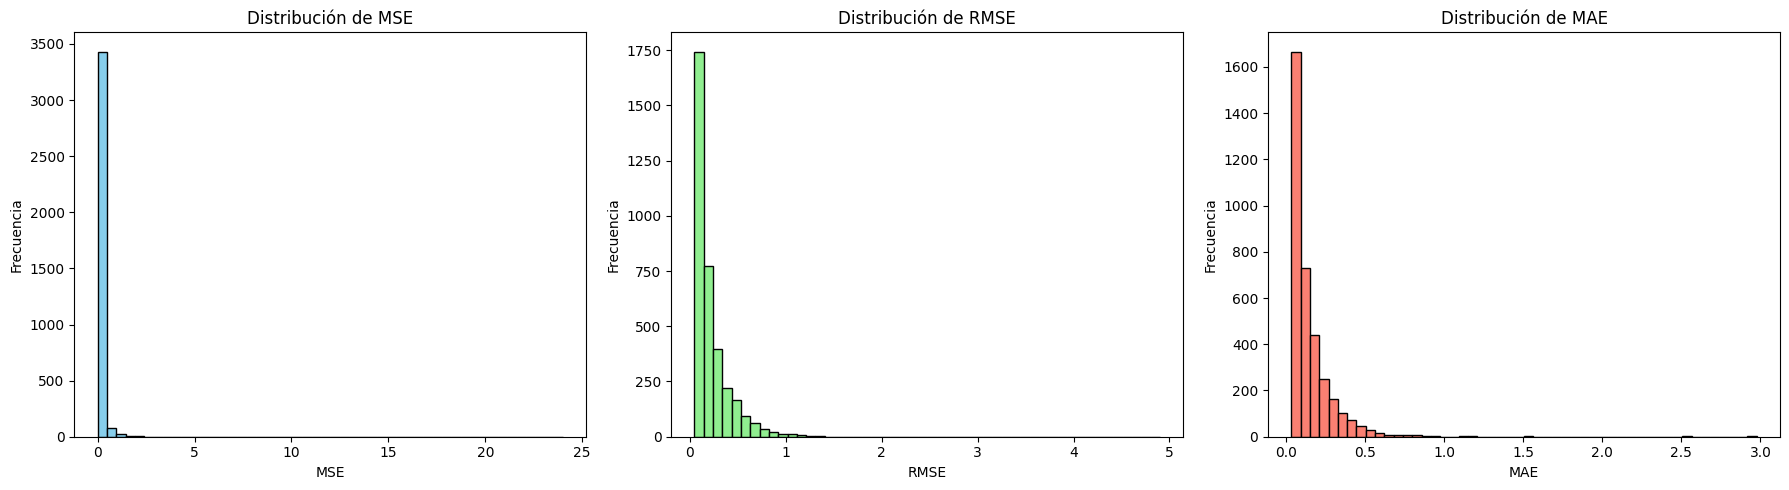

In [11]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(mse_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

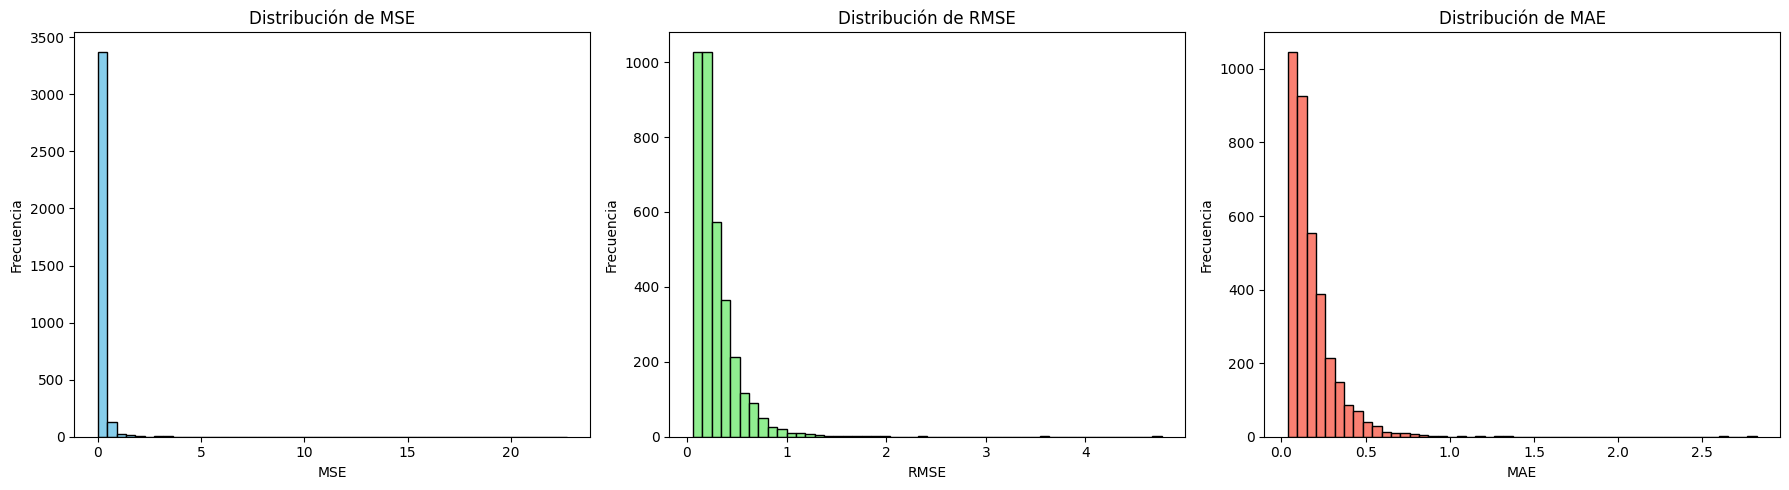

In [12]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.hist(mse_full_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_full_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_full_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Se puede observar que para las tres distribuciones (MSE, RMSE, MAE), la mayoría de muestras tienen errores bajos, y solamente unas pocas tienen errores altos, lo que nos indica que son posibles outliers o ejemplos difíciles de reconstruir.

🟦 Distribución por MSE:
- Se ve un pico pronunciado cerca del 0, es decir, la mayoría de entradas se han reconstruído correctamente
- Tenemos unos cuantos ejemplos con MSE > 1 y algunos extremos que podrían ser anomalías o errores en la reconstrucción

🟩 Distribución de RMSE:
- Muy parecida al MSE
- La mayoría está por debajo de 0.5, lo que es un buen signo

🟥 Distribución de MAE:
- La mayoría de errores son bajos (0 - 0.2)
- Es menos sensible a errores extremos, pero también hay algunos ejemplos con MAE > 2

In [13]:
umbral_rmse = 1.0
outliers = np.where(rmse_vectors > umbral_rmse)[0]
print(f'{len(outliers)} muestras con RMSE > {umbral_rmse}')

41 muestras con RMSE > 1.0


#### Variational Autoencoder (VAE)

In [14]:
class Sampling(tf.keras.layers.Layer):
    """Clase de muestreo para el VAE"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = Input(shape=(input_dim,), name='encoder_input')
    encoded = Dense(512, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(encoded)
    z_log_var = Dense(latent_dim, name='z_log_var')(encoded)
    z = Sampling(name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    h_decoded = Dense(512, activation='relu')(latent_inputs)
    outputs = Dense(input_dim, activation='sigmoid')(h_decoded)
    
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE
    outputs = decoder(encoder(inputs)[2])  # Pasa z (muestreo) a través del decoder
    vae = Model(inputs, outputs, name='vae')

    return vae, encoder, decoder

# Pérdida de Reconstrucción (MSE o Binary Crossentropy)
def reconstruction_loss(x, x_decoded):
    return MeanSquaredError()(x, x_decoded)

# Pérdida KL
def kl_loss(z_mean, z_log_var):
    return -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

# Pérdida total (reconstrucción + KL)
def vae_loss(x, x_decoded, z_mean, z_log_var, beta=0.1):
    r_loss = reconstruction_loss(x, x_decoded)
    k_loss = kl_loss(z_mean, z_log_var)
    return r_loss +  k_loss

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [15]:
vae, vae_encoder, vae_decoder = build_vae(input_dim=X.shape[1], latent_dim=128)

vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

vae.summary()
vae.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test), callbacks=[early_stopping])

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 128), (None,   │       669,952 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1051)           │       605,211 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,163 (4.86 MB)

 Trainable params: 1,275,163 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 610184.9375 - val_loss: 5.1029
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0078 - val_loss: 2.4830
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1936 - val_loss: 1.9950
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9017 - val_loss: 1.6829
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6152 - val_loss: 1.6082
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4116 - val_loss: 1.5251
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4156 - val_loss: 1.4775
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3395 - val_loss: 1.4992
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3843 - val_loss: 1.3500
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3686 - val_loss: 1.3989
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2840 - val_loss: 1.3148
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss

In [16]:
vae_full, vae_encoder_full, vae_decoder_full = build_vae(input_dim=X_full.shape[1], latent_dim=128)
vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))
vae_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test), callbacks=[early_stopping])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2135.2544 - val_loss: 7.8041
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7144 - val_loss: 2.5778
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2873 - val_loss: 2.1246
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9141 - val_loss: 1.7318
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6628 - val_loss: 1.6129
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5466 - val_loss: 1.4710
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4688 - val_loss: 1.4692
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3534 - val_loss: 1.4159
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3519 - val_loss: 1.6224
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4452 - val_loss: 1.3598
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2965 - val_loss: 1.4789
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 

Entrenamos finalmente nuestros autencoder con todo el dataset.

In [17]:
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)
encoded_vectors = encoder.predict(X)
autoencoder.save("models/autoencoder.keras")
encoder.save("models/encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0781
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1069
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1501
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1018
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1040
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1301
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1155
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0944
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1142
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1018
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0817
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0815
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0752
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0813
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0835
Epoch 16/50
70/70 

In [18]:
autoencoder_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
encoded_full_vectors = encoder_full.predict(X_full)
autoencoder_full.save("models/autoencoder_full.keras")
encoder_full.save("models/encoder_full.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1051
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1266
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1279
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1446
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1178
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1154
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1279
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1085
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1093
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1009
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1011
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0997
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0945
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0921
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0930
Epoch 16/50
70/70 ━

In [19]:
vae.fit(X, X, epochs=50, batch_size=256, shuffle=True)
vae_encoded_vectors = vae_encoder.predict(X, batch_size=32)
vae.save("models/vae.keras")
vae_encoder.save("models/vae_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1509
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0629
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0903
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0714
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0880
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1563
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0543
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0966
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0786
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0127
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0448
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0474
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9921
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0783
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9953
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [20]:
vae_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
vae_encoded_full_vectors = vae_encoder_full.predict(X_full, batch_size=32)
vae_full.save("models/vae_full.keras")
vae_encoder_full.save("models/vae_full_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2066
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1607
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0869
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1094
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0970
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0522
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0664
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0308
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0923
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0802
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0797
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0504
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0767
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0132
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0587
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [21]:
df_embeddings = pd.DataFrame({
    'clip_id': features_df['clip_id'].values,
    'original_embeddings': list(vectors),
    'encoded_embeddings': list(encoded_vectors),
    'original_full_embeddings': list(full_vectors),
    'encoded_full_embeddings': list(encoded_full_vectors),
    'vae_embeddings': list(vae_encoded_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
    'vae_full_embeddings': list(vae_encoded_full_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
})
df_embeddings.to_sql('embeddings', sqlite3.connect('dataset/embeddings.db'), if_exists='replace', index=False)

17783

In [22]:
def get_genres():
    """Obtiene los géneros de la base de datos"""
    conn = sqlite3.connect("dataset/genres.db")
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()
    genres_df.drop(columns=['mp3_path'], inplace=True)

    genres_df = genres_df.melt(id_vars=['clip_id'], var_name='genre', value_name='value')
    genres_df = genres_df[genres_df['value'] == 1]
    genres_df = genres_df.drop(columns=['value'])

    genres_df = genres_df.groupby('clip_id')['genre'].apply(lambda x: list(x)).reset_index()
    genres_df.rename(columns={'genre': 'genres'}, inplace=True)
    genres_df['genres'] = genres_df['genres'].apply(lambda x: ', '.join(x))
    return genres_df


genres_df = get_genres()

all_genres = set()
for genre_str in genres_df['genres']:
    genres = [g.strip().lower() for g in genre_str.split(',')]
    all_genres.update(genres)

# Mapear géneros a posiciones lineales en [0, 1] y aplicar viridis
sorted_genres = sorted(all_genres)
genre_to_value = {genre: i / (len(sorted_genres) - 1) for i, genre in enumerate(sorted_genres)}
cmap = plt.get_cmap('gist_rainbow')
genre_colors = {genre: cmap(genre_to_value[genre]) for genre in sorted_genres}

def blend_colors(genre_list):
    colors = [np.array(genre_colors[g]) for g in genre_list if g in genre_colors]
    avg_color = np.mean(colors, axis=0)
    return tuple(avg_color)

# Asignar color mezclado a cada canción
clip_colors = []
for genre_str in genres_df['genres']:
    genres = [g.strip().lower() for g in genre_str.split(',')]
    mixed_color = blend_colors(genres)
    clip_colors.append(mixed_color)

In [23]:
# Visualización del espacio latente del autoencoder y el variational autoencoder
def plot_latent_space(latent_space_1, latent_space_2, title):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(latent_space_1[:, 0], latent_space_1[:, 1], alpha=0.5, c=clip_colors)
    plt.title('Espacio Latente del Autoencoder')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.scatter(latent_space_2[:, 0], latent_space_2[:, 1], alpha=0.5, c=clip_colors)
    plt.title('Espacio Latente del VAE')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

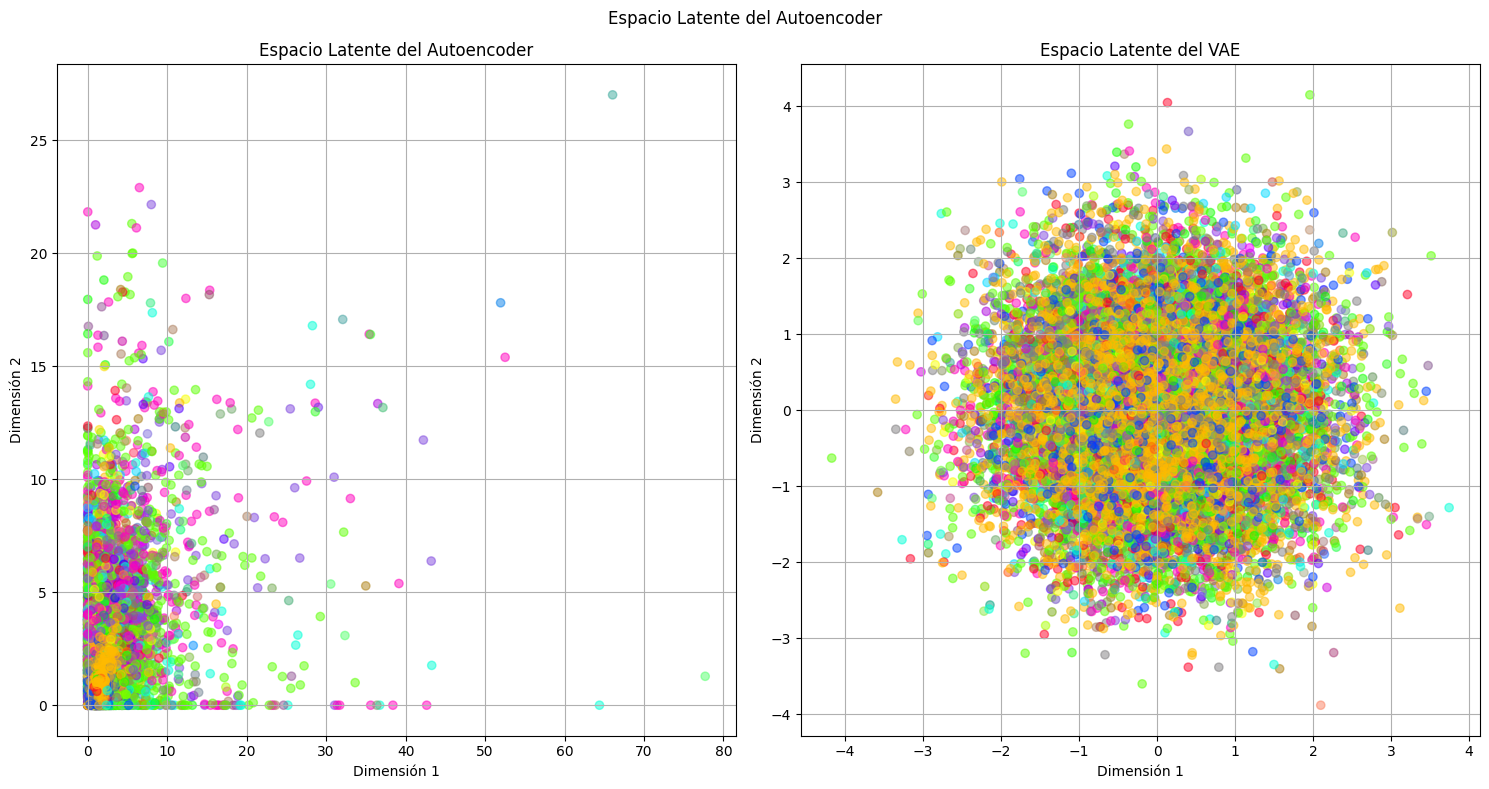

In [24]:
plot_latent_space(encoded_vectors, vae_encoded_vectors[2] ,'Espacio Latente del Autoencoder')

### Similitud entre vectores

#### K-Nearest Neighbors